In [279]:
import os as os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

# Set color tunes

In [498]:
# Severity
severity_palette = sns.color_palette(['#2aeeda','#ffae3c','#f83249'])
model_palette = sns.color_palette(['#C2185B','#1A51AD','#58efcd'])

# Calculate overall proportions

In [347]:
# Set parental work directory
parental = '/home/aimmunelab/lab_members/Harris/COVID_Project/Datasets_selected'
os.chdir(parental)

In [392]:
# Read Dataset
aggregate = sc.read('aggregate_annotated.h5ad')

In [393]:
batchlist = aggregate.obs['batch'].value_counts().index

In [394]:
batchlist

CategoricalIndex(['Moderate 0', 'Healthy 8', 'Moderate 2', 'Healthy 11',
                  'Healthy 12', 'Healthy 7', 'Severe 2', 'Severe 10',
                  'Healthy 10', 'Healthy 9', 'Severe 6', 'Moderate 1',
                  'Healthy 0', 'Healthy 5', 'Healthy 4', 'Severe 11',
                  'Healthy 6', 'Severe 5', 'Severe 1', 'Healthy 1', 'Severe 9',
                  'Severe 3', 'Moderate 4', 'Healthy 2', 'Severe 4',
                  'Severe 7', 'Healthy 24', 'Healthy 14', 'Severe 0',
                  'Healthy 21', 'Moderate 13', 'Healthy 20', 'Healthy 26',
                  'Healthy 3', 'Healthy 15', 'Moderate 5', 'Moderate 3',
                  'Moderate 11', 'Healthy 25', 'Healthy 18', 'Moderate 8',
                  'Severe 8', 'Severe 13', 'Healthy 17', 'Healthy 23'],
                 categories=['Healthy 0', 'Healthy 1', 'Healthy 2', 'Healthy 3', 'Healthy 4', 'Healthy 5', 'Healthy 6', 'Healthy 7', ...], ordered=False, dtype='category')

In [395]:
clusters = aggregate.obs['leiden'].value_counts().index

In [396]:
def CalculateProportion(adata,clusters=clusters):
    proportion = float
    proportion_ls = np.array([])
    for i in clusters:
        proportion = len(adata[adata.obs['leiden']==i])/len(adata)
        proportion_ls = np.append(proportion_ls, proportion)
    proportion_df = pd.DataFrame({'Cluster name':clusters,'Proportion':proportion_ls})
    return proportion_df

In [397]:
def Grouping(batchlist,group=str):
    grouplist = []
    for i in batchlist:
        if group in i:
            grouplist.append(i)
    return grouplist

In [398]:
healthy_group = Grouping(batchlist,'Healthy')
moderate_group = Grouping(batchlist, 'Moderate')
severe_group = Grouping(batchlist, 'Severe')
severe_group

['Severe 2',
 'Severe 10',
 'Severe 6',
 'Severe 11',
 'Severe 5',
 'Severe 1',
 'Severe 9',
 'Severe 3',
 'Severe 4',
 'Severe 7',
 'Severe 0',
 'Severe 8',
 'Severe 13']

In [399]:
def ProportionInGroup(group):
    proportion_group = pd.DataFrame()
    for i in group:
        proportion_group = proportion_group.append(
            CalculateProportion(aggregate[aggregate.obs['batch']==i]))
    return proportion_group

In [400]:
proportion_healthy_group = ProportionInGroup(healthy_group)
proportion_moderate_group = ProportionInGroup(moderate_group)
proportion_severe_group = ProportionInGroup(severe_group)

In [401]:
healthy_batch = []
for i in range(0,len(healthy_group)):
    healthy_batch+=(['Healthy '+str(i)]*len(clusters))
proportion_healthy_group['Batch'] = healthy_batch
moderate_batch = []
for i in range(0,len(moderate_group)):
    moderate_batch+=(['Moderate '+str(i)]*len(clusters))
proportion_moderate_group['Batch'] = moderate_batch
severe_batch = []
for i in range(0,len(severe_group)):
    severe_batch+=(['Severe '+str(i)]*len(clusters))
proportion_severe_group['Batch'] = severe_batch

In [402]:
proportion_aggregate = proportion_healthy_group.append([proportion_moderate_group,proportion_severe_group])

In [403]:
proportion_aggregate.to_csv('proportion_ground_truth_aggregate.csv')

In [404]:
len(proportion_aggregate)

315

In [405]:
group = []
group+=(['Healthy']*len(clusters))*len(healthy_group)
group+=(['Moderate']*len(clusters))*len(moderate_group)
group+=(['Severe']*len(clusters))*len(severe_group)
proportion_aggregate['Group'] = group
proportion_aggregate.to_csv('proportion_aggregate.csv')

In [406]:
proportion_aggregate = pd.read_csv('proportion_aggregate.csv', index_col='Unnamed: 0')

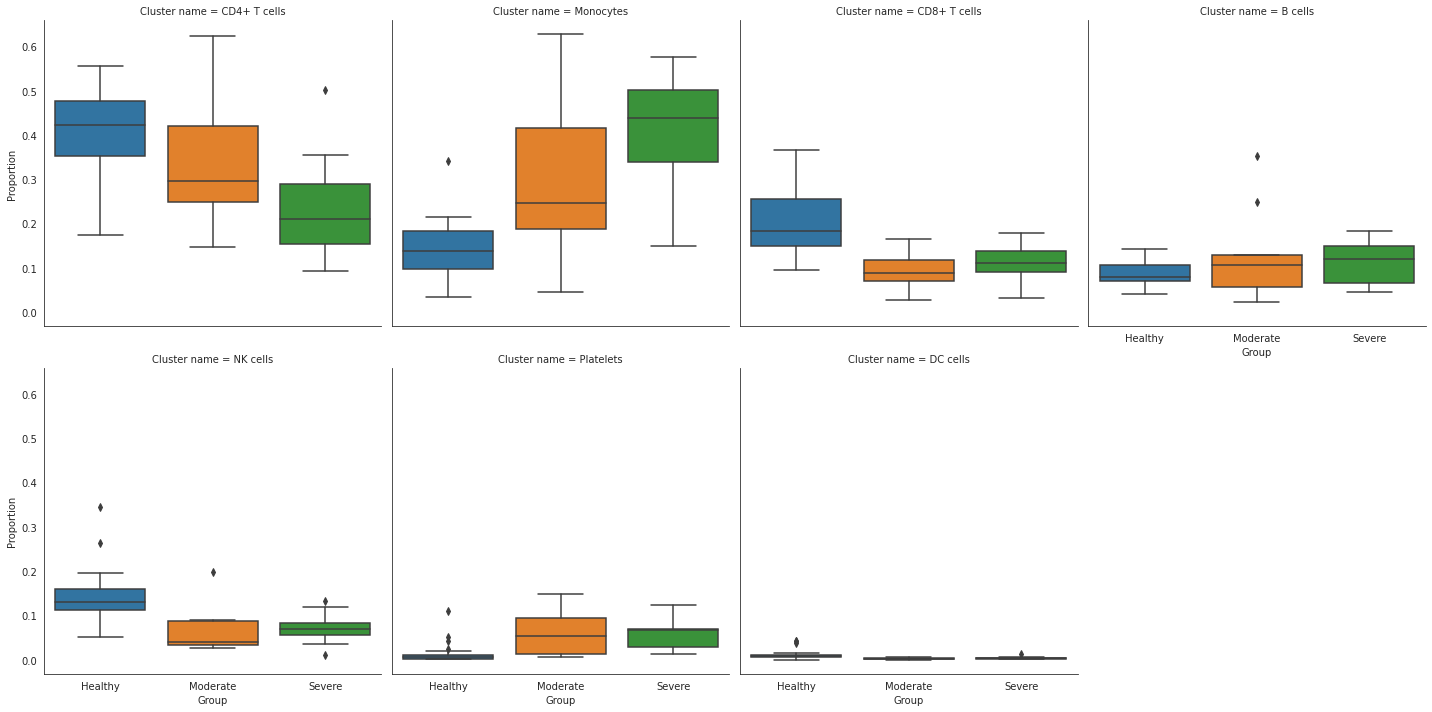

In [407]:
sns.catplot(y='Proportion', x='Group',col='Cluster name', data=proportion_aggregate, kind='box', col_wrap=4)

In [408]:
len(proportion_aggregate['Batch'].value_counts())

45

# Statistical test

In [409]:
import scipy

In [410]:
# paried-grouping
hd_md = proportion_aggregate[proportion_aggregate['Group']!='Severe']
hd_se = proportion_aggregate[proportion_aggregate['Group']!='Moderate']
md_se = proportion_aggregate[proportion_aggregate['Group']!='Healthy']

In [411]:
for i in md_se['Cluster name'].value_counts().index:
    print(i)
    comp = md_se[md_se['Cluster name']==i]
    print(scipy.stats.ttest_ind(comp[comp['Group']=='Moderate']['Proportion'], 
                               comp[comp['Group']=='Severe']['Proportion'], equal_var=False))

CD4+ T cells
Ttest_indResult(statistic=1.6882522833268387, pvalue=0.11413319849568362)
Monocytes
Ttest_indResult(statistic=-1.3626149097655278, pvalue=0.1943316824227859)
CD8+ T cells
Ttest_indResult(statistic=-1.1720488236308129, pvalue=0.25740843195561636)
B cells
Ttest_indResult(statistic=0.5025332451587896, pvalue=0.6257423380728785)
NK cells
Ttest_indResult(statistic=-0.14946875146144573, pvalue=0.8836717166980093)
Platelets
Ttest_indResult(statistic=0.1620824061141543, pvalue=0.8737432342265968)
DC cells
Ttest_indResult(statistic=-0.9181684384646841, pvalue=0.3696754096901582)


In [412]:
for i in hd_md['Cluster name'].value_counts().index:
    print(i)
    comp = hd_md[hd_md['Cluster name']==i]
    print(scipy.stats.ttest_ind(comp[comp['Group']=='Healthy']['Proportion'], 
                               comp[comp['Group']=='Moderate']['Proportion'], equal_var=False))

CD4+ T cells
Ttest_indResult(statistic=1.1481094156265368, pvalue=0.27585386775078186)
Monocytes
Ttest_indResult(statistic=-2.6693672089550713, pvalue=0.025801572293503276)
CD8+ T cells
Ttest_indResult(statistic=5.111652365118968, pvalue=2.8975360920601914e-05)
B cells
Ttest_indResult(statistic=-1.1605718100300813, pvalue=0.27788554981291136)
NK cells
Ttest_indResult(statistic=3.348205158791298, pvalue=0.0037969183516336847)
Platelets
Ttest_indResult(statistic=-2.578209288210513, pvalue=0.02870376426048121)
DC cells
Ttest_indResult(statistic=3.179636083106331, pvalue=0.0038230119831124017)


In [413]:
for i in hd_se['Cluster name'].value_counts().index:
    print(i)
    comp = hd_se[hd_se['Cluster name']==i]
    print(scipy.stats.ttest_ind(comp[comp['Group']=='Healthy']['Proportion'], 
                               comp[comp['Group']=='Severe']['Proportion'], equal_var=False))

CD4+ T cells
Ttest_indResult(statistic=4.432280987842213, pvalue=0.0001937437577127666)
Monocytes
Ttest_indResult(statistic=-6.4606908098932205, pvalue=9.015104819728634e-06)
CD8+ T cells
Ttest_indResult(statistic=4.4738718360361, pvalue=8.18094810140027e-05)
B cells
Ttest_indResult(statistic=-1.529659659543585, pvalue=0.1460608324309265)
NK cells
Ttest_indResult(statistic=4.499422420273079, pvalue=7.655229558966716e-05)
Platelets
Ttest_indResult(statistic=-3.953209789500631, pvalue=0.000861118329261316)
DC cells
Ttest_indResult(statistic=2.7696757088090114, pvalue=0.010136248232638177)


In [414]:
proportion_significance_tuple = [(0,1), (1,1), (1,1), (0,0), (1,1), (1,1), (1,1)]

In [415]:
predicted = pd.read_csv('Deconvolution_results.csv', index_col='Unnamed: 0')

In [416]:
proportion_aggregate

,Cluster name,Proportion,Batch,Group
0,CD4+ T cells,0.488046,Healthy 0,Healthy
1,Monocytes,0.138299,Healthy 0,Healthy
2,CD8+ T cells,0.147919,Healthy 0,Healthy
3,B cells,0.125726,Healthy 0,Healthy
4,NK cells,0.081722,Healthy 0,Healthy
...,...,...,...,...
2,CD8+ T cells,0.122154,Severe 12,Severe
3,B cells,0.120841,Severe 12,Severe
4,NK cells,0.058231,Severe 12,Severe
5,Platelets,0.035026,Severe 12,Severe


In [417]:
cluster_names = ['CD4+ T cells', 'Monocytes', 'NK cells', 'B cells', 'CD8+ T cells',
       'Platelets', 'DC cells']

In [418]:
batches = proportion_aggregate['Batch'].values

In [419]:
prediction_rearange = []
for i in range(45):
    for j in cluster_names:
        prediction_rearange.append(predicted[predicted['Cluster']==j]['Prediction'][i])

In [420]:
proportion_aggregate['Prediction'] = prediction_rearange

In [421]:
proportion_aggregate

,Cluster name,Proportion,Batch,Group,Prediction
0,CD4+ T cells,0.488046,Healthy 0,Healthy,0.354695
1,Monocytes,0.138299,Healthy 0,Healthy,0.194644
2,CD8+ T cells,0.147919,Healthy 0,Healthy,0.218660
3,B cells,0.125726,Healthy 0,Healthy,0.180850
4,NK cells,0.081722,Healthy 0,Healthy,0.152847
...,...,...,...,...,...
2,CD8+ T cells,0.122154,Severe 12,Severe,0.193482
3,B cells,0.120841,Severe 12,Severe,0.172058
4,NK cells,0.058231,Severe 12,Severe,0.126108
5,Platelets,0.035026,Severe 12,Severe,0.067413


In [ ]:
for i in hd_se['Cluster name'].value_counts().index:
    print(i)
    comp = hd_se[hd_se['Cluster name']==i]
    print(scipy.stats.ttest_ind(comp[comp['Group']=='Healthy']['Proportion'], 
                               comp[comp['Group']=='Severe']['Proportion'], equal_var=False))

In [ ]:
plt.figure(figsize=(15,10), dpi=100)
plt.figure(1)
loc = 341
for i in cluster_names:
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    ax = plt.subplot(loc)
    plt.title(i)
    ax = sns.boxplot(x='Group', y='Prediction',
                data=proportion_aggregate[proportion_aggregate['Cluster name']==i],palette='colorblind')
    loc+=1

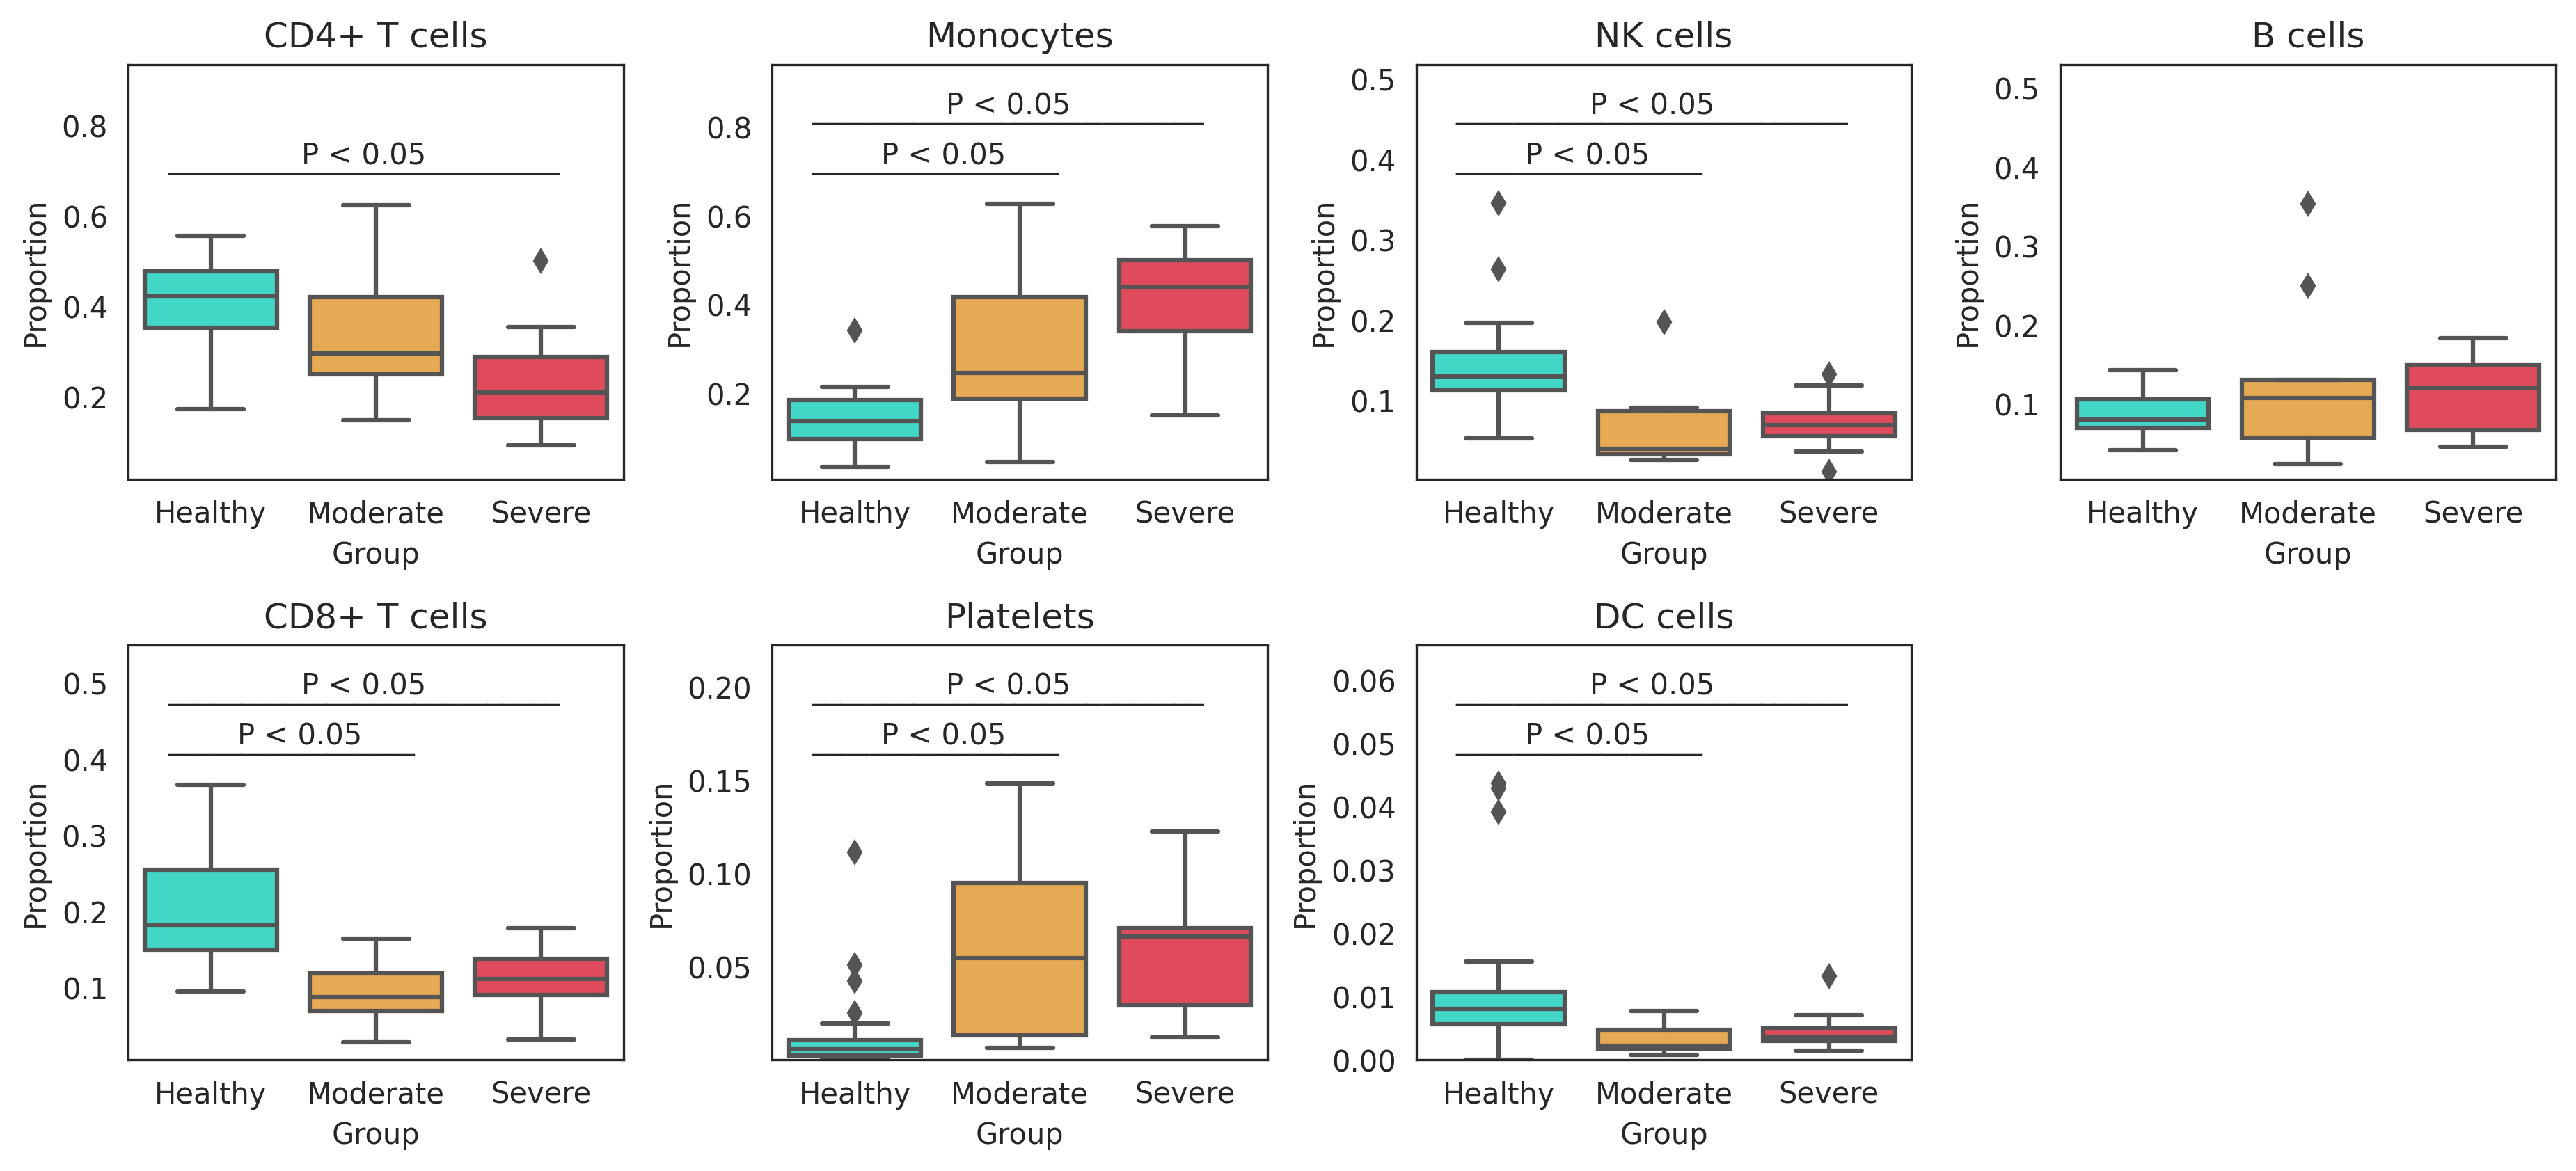

In [499]:
plt.figure(figsize=(15,10), dpi=300)
plt.figure(1)
loc = 341
for i in range(7):
    cluster = cluster_names[i]
    significance_tuple = proportion_significance_tuple[i]
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    ax = plt.subplot(loc)
    plt.title(cluster)
    ax = sns.boxplot(x='Group', y='Proportion',
                data=proportion_aggregate[proportion_aggregate['Cluster name']==cluster], palette=severity_palette)
    plt.ylim([min(proportion_aggregate[proportion_aggregate['Cluster name']==cluster]['Proportion'])*0.2, 
             max(proportion_aggregate[proportion_aggregate['Cluster name']==cluster]['Proportion'])*1.5])
    loc+=1
    if significance_tuple == (0,0):
        continue
    if significance_tuple == (1,1):
        plt.text(0.08,0.75,'_________________', transform=ax.transAxes)
        plt.text(0.22,0.76,'P < 0.05', transform=ax.transAxes)
        plt.text(0.08,0.87,'___________________________', transform=ax.transAxes)
        plt.text(0.35,0.88,'P < 0.05', transform=ax.transAxes)
    if significance_tuple == (0,1):
        plt.text(0.08,0.75,'___________________________', transform=ax.transAxes)
        plt.text(0.35,0.76,'P < 0.05', transform=ax.transAxes)
    if significance_tuple == (1,0):
        plt.text(0.08,0.75,'_________________', transform=ax.transAxes)
        plt.text(0.22,0.76,'P < 0.05', transform=ax.transAxes)

In [445]:
validation = pd.DataFrame({'Proportion':proportion_aggregate['Proportion'].append(proportion_aggregate['Prediction']),
                           'Cluster name':proportion_aggregate['Cluster name'].append(proportion_aggregate['Cluster name']),
                           'Prediction or GT':['Ground truth']*len(proportion_aggregate)+['AIm Prediction']*len(proportion_aggregate),
                           'Group':proportion_aggregate['Group'].append(proportion_aggregate['Group'])})

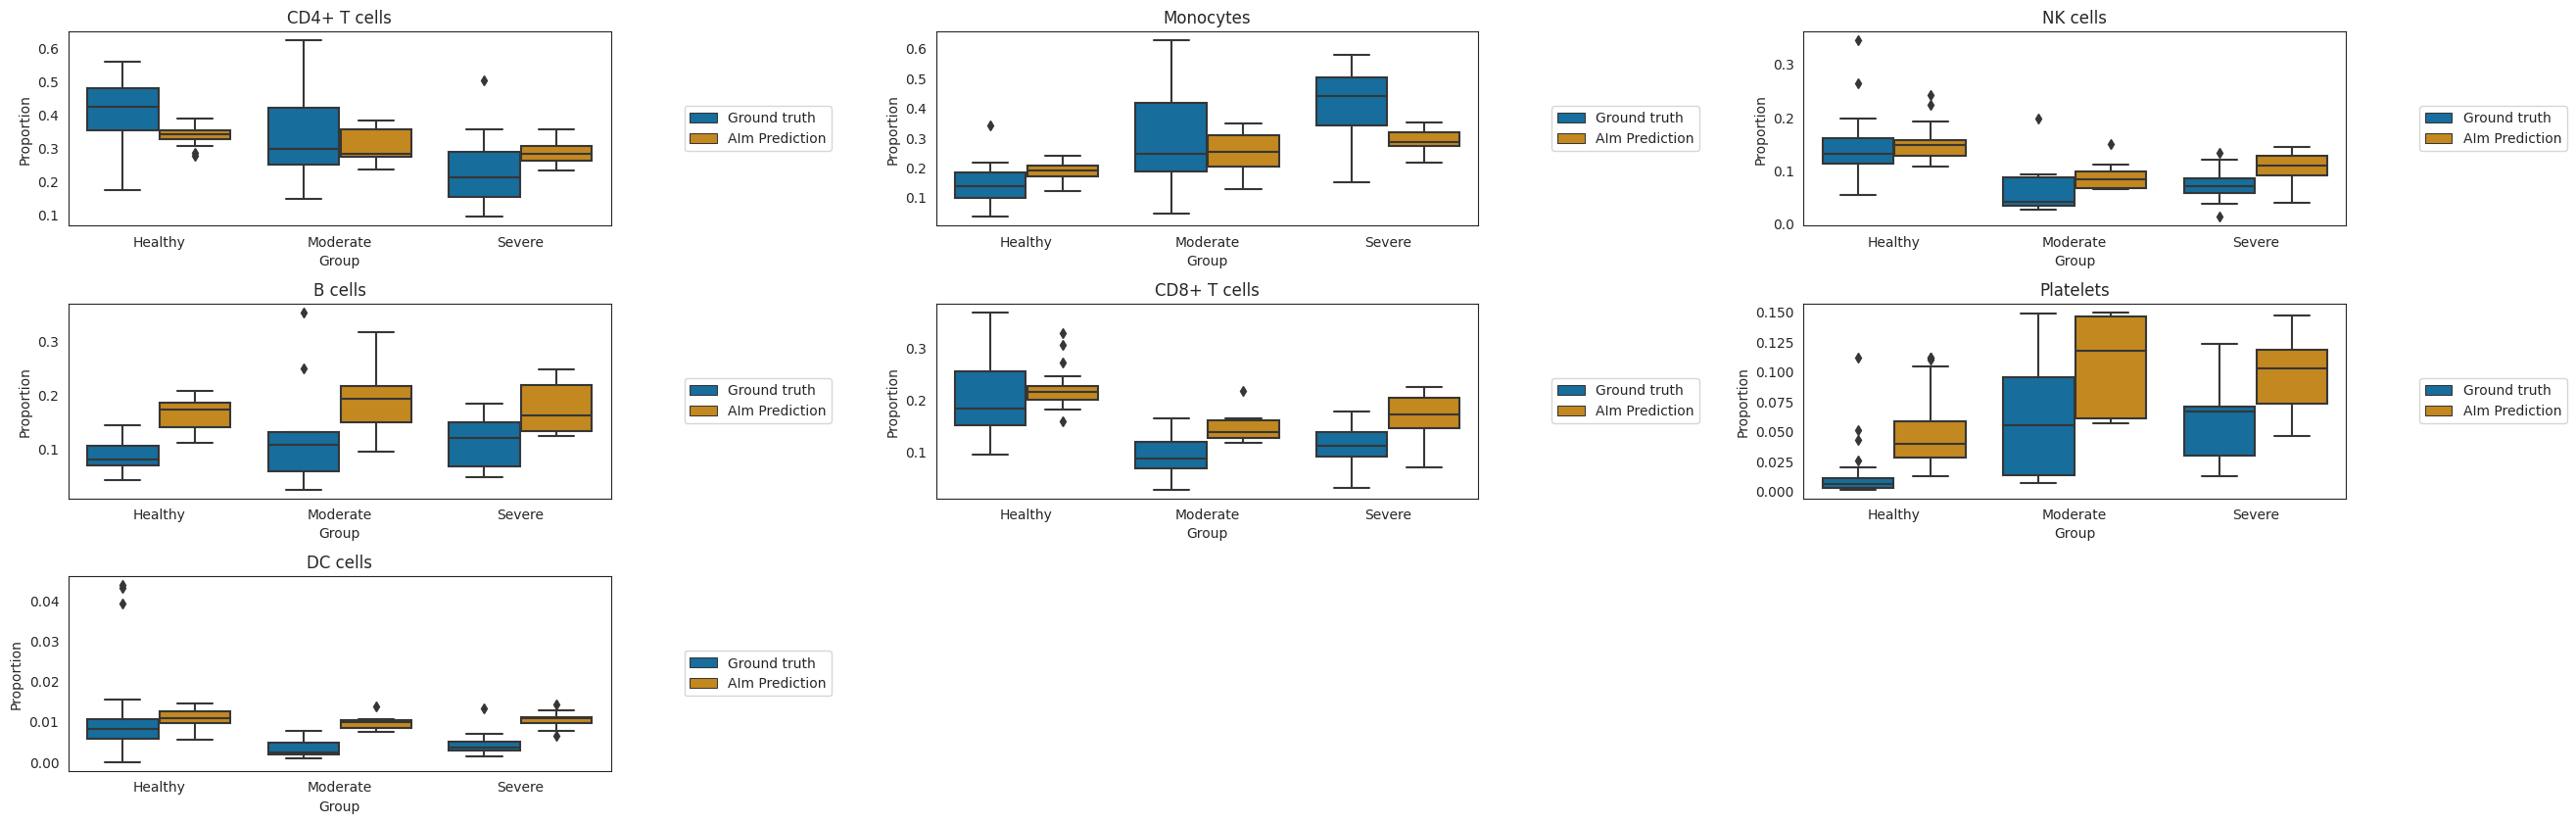

In [446]:
plt.figure(figsize=(30,10), dpi=100)
plt.figure(1)
loc = 331
for i in cluster_names:
    plt.subplots_adjust(wspace=0.6, hspace=0.4)
    ax = plt.subplot(loc)
    plt.title(i)
    ax = sns.boxplot(x='Group', y='Proportion',hue='Prediction or GT',
                data=validation[validation['Cluster name']==i],palette='colorblind')
    plt.legend(loc='center right', bbox_to_anchor=(1.42, 0.5))
    loc+=1

# CIBERSORTx Reuslts

In [426]:
csx_results = pd.read_csv('CIBERSORTx_Job19_Results.csv')

In [427]:
def AddingCSxRsults(csinput):
    cspropotions = np.array([])
    for i in csinput['Mixture']:
        print('Sample '+i)
        print('CD4+ T cells')
        cspropotions = np.append(cspropotions,csx_results[csx_results['Mixture']==i][['T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated']].T.sum())
        print('Monocytes')
        cspropotions = np.append(cspropotions,csx_results[csx_results['Mixture']==i][['Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2']].T.sum())
        print('NK Cells')
        cspropotions = np.append(cspropotions,csx_results[csx_results['Mixture']==i][['NK cells resting','NK cells activated']].T.sum())
        print('B Cells')
        cspropotions = np.append(cspropotions,csx_results[csx_results['Mixture']==i][['B cells naive', 'B cells memory', 'Plasma cells']].T.sum())
        print('CD8+ T cells')
        cspropotions = np.append(cspropotions,csx_results[csx_results['Mixture']==i][['T cells CD8']].T.sum())
        print('Platelets')
        cspropotions = np.append(cspropotions,0)
        print('DC Cells')
        cspropotions = np.append(cspropotions,csx_results[csx_results['Mixture']==i][['Dendritic cells resting','Dendritic cells activated']].T.sum())
    return cspropotions

In [428]:
csx_to_be_added = validation.iloc[:int(len(validation)/2),:]
csx_to_be_added['Proportion'] = AddingCSxRsults(csx_results)

Sample Healthy 0
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 1
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 2
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 3
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 4
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 5
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 6
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 7
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 8
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 9
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 10
CD4+ T cells
Monocytes
NK Cells
B Cells
CD8+ T cells
Platelets
DC Cells
Sample Healthy 11
CD

/tmp/ipykernel_18955/2058247769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csx_to_be_added['Proportion'] = AddingCSxRsults(csx_results)


In [429]:
csx_to_be_added['Prediction or GT'] = ['CSx Prediction']*len(csx_to_be_added)

/tmp/ipykernel_18955/2411129454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csx_to_be_added['Prediction or GT'] = ['CSx Prediction']*len(csx_to_be_added)


In [430]:
csx_to_be_added

,Proportion,Cluster name,Prediction or GT,Group
0,0.125038,CD4+ T cells,CSx Prediction,Healthy
1,0.140476,Monocytes,CSx Prediction,Healthy
2,0.128483,CD8+ T cells,CSx Prediction,Healthy
3,0.030037,B cells,CSx Prediction,Healthy
4,0.552987,NK cells,CSx Prediction,Healthy
...,...,...,...,...
2,0.125980,CD8+ T cells,CSx Prediction,Severe
3,0.027543,B cells,CSx Prediction,Severe
4,0.136669,NK cells,CSx Prediction,Severe
5,0.000000,Platelets,CSx Prediction,Severe


In [447]:
validation_3 = validation.append(csx_to_be_added)

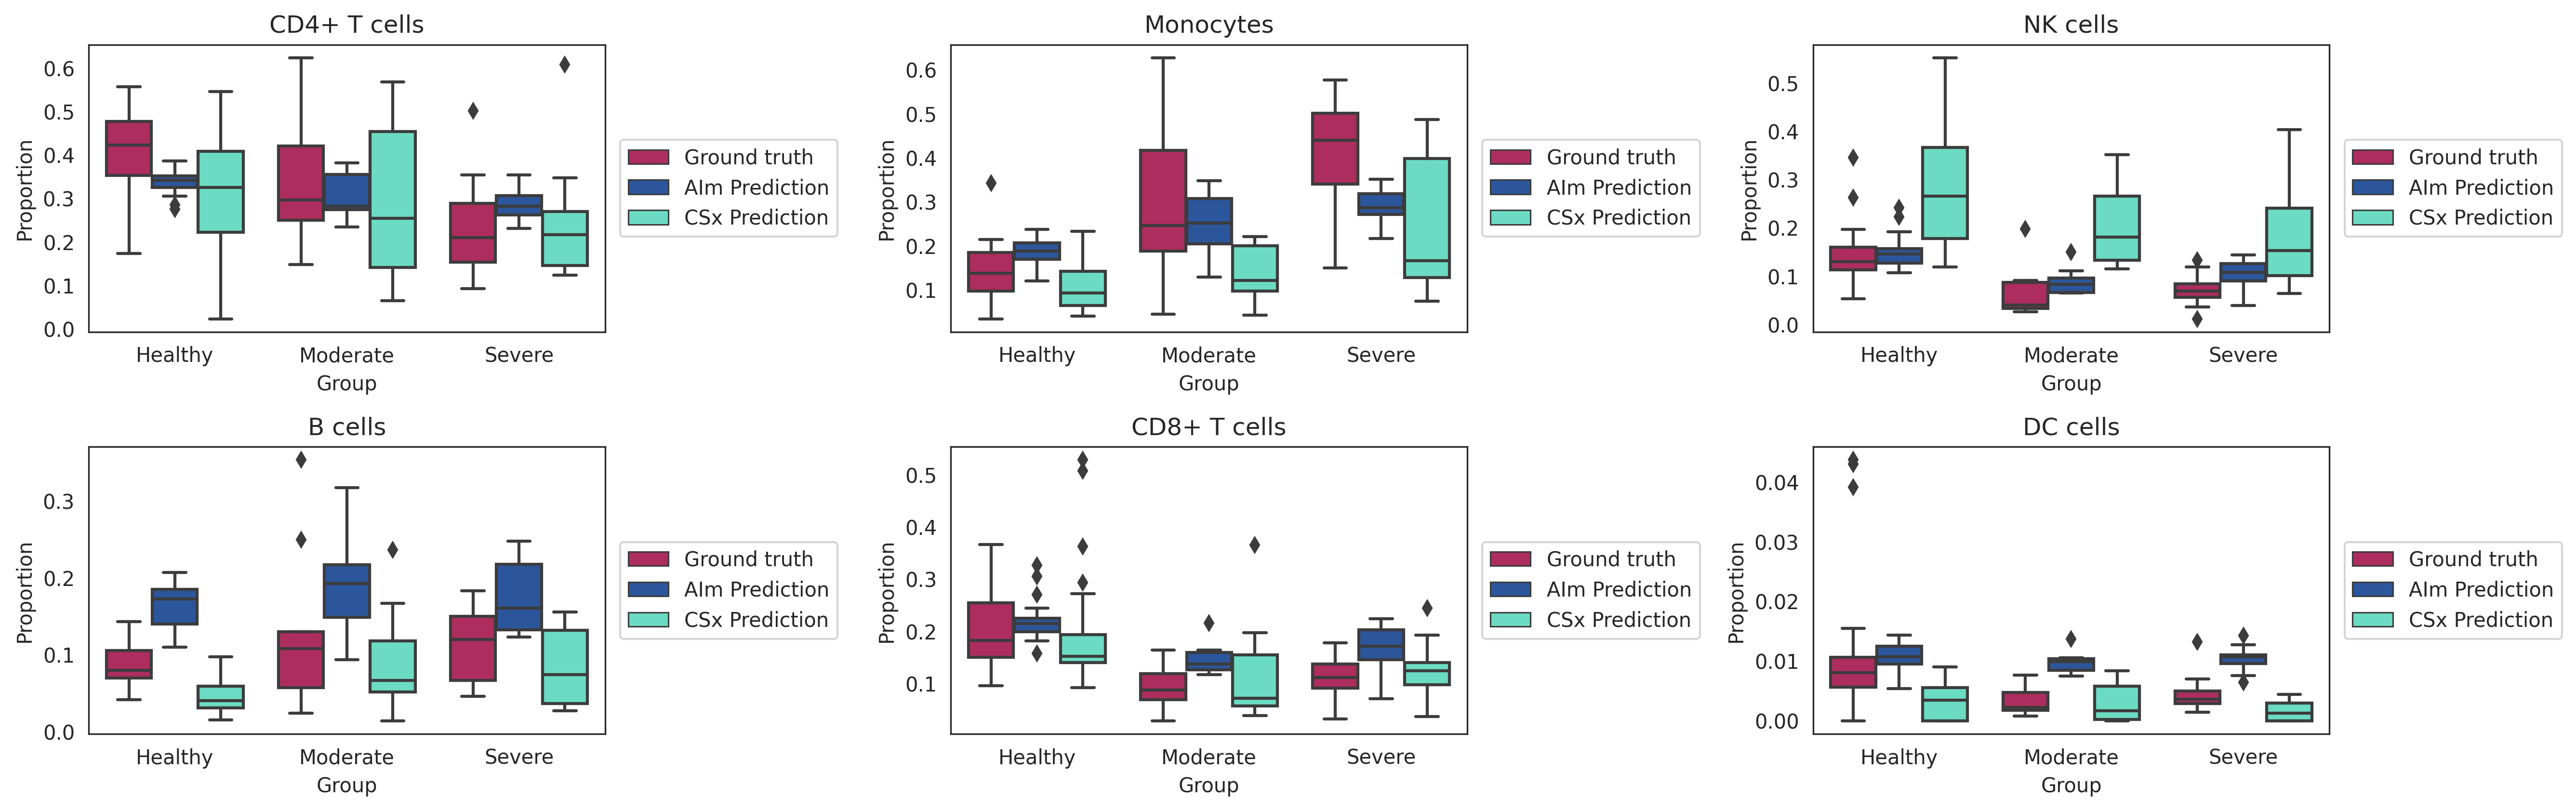

In [503]:
plt.figure(figsize=(20,10), dpi=300)
plt.figure(1)
loc = 331
for i in cluster_names:
    plt.subplots_adjust(wspace=0.67, hspace=0.4)
    ax = plt.subplot(loc)
    plt.title(i)
    ax = sns.boxplot(x='Group', y='Proportion',hue='Prediction or GT',
                data=validation_3[validation_3['Cluster name']==i], palette=model_palette)
    plt.legend(loc='center right', bbox_to_anchor=(1.47, 0.5))
    loc+=1

In [449]:
from sklearn.metrics import mean_squared_error

In [504]:
mse_csx = []
mse_aim = []
for i in cluster_names:
    mse_csx.append(mean_squared_error(csx_to_be_added[csx_to_be_added['Cluster name']==i]['Proportion'], 
                                     proportion_aggregate[proportion_aggregate['Cluster name']==i]['Proportion']))
for i in cluster_names:
    mse_aim.append(mean_squared_error(proportion_aggregate[proportion_aggregate['Cluster name']==i]['Prediction'], 
                                     proportion_aggregate[proportion_aggregate['Cluster name']==i]['Proportion']))
mse_df = pd.DataFrame({'Cluster':cluster_names,
              'Value':mse_aim,
              'Model':['AImmune']*len(cluster_names)}).append(
pd.DataFrame({'Cluster':cluster_names,
              'Value':mse_csx,
              'Model':['CIBERSORTx']*len(cluster_names)}))
mse_df.columns = ['Cluster', 'MSE', "Model"]

<AxesSubplot:xlabel='Model', ylabel='MSE'>

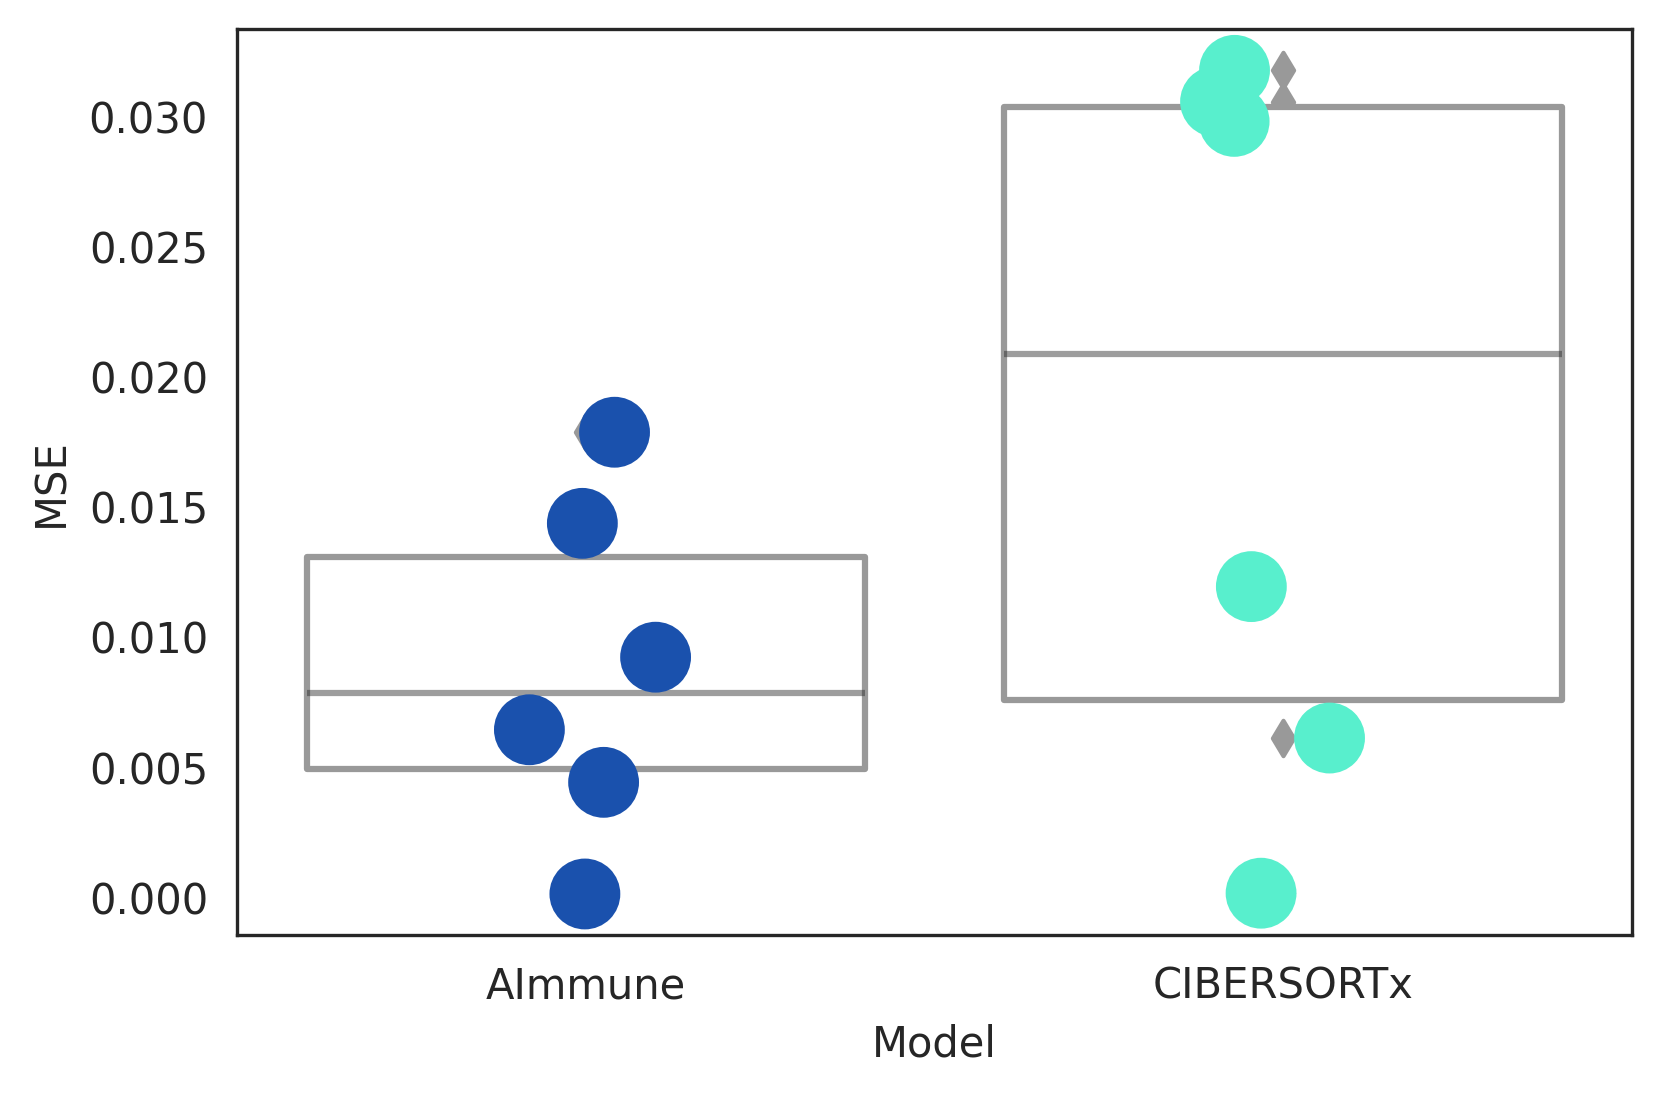

In [505]:
plt.figure(dpi=300)
sns.boxenplot(x='Model', y='MSE', data=mse_df, color='white')
sns.stripplot(x='Model', y='MSE', data=mse_df, palette=model_palette[1:], size=17)

In [506]:
print('MSE of AImmune is:')
print(mse_df[mse_df['Model']=='AImmune']['MSE'].mean())
print('MSE of CIBERSORTx is:')
print(mse_df[mse_df['Model']=='CIBERSORTx']['MSE'].mean())

MSE of AImmune is:
0.008724331193250673
MSE of CIBERSORTx is:
0.01838575122795042


In [453]:
correlation_list_csx = pd.DataFrame()
correlation_list_csx['Prediction'] = validation_3[validation_3['Prediction or GT']=='CSx Prediction']['Proportion']
correlation_list_csx['Ground Truth'] = validation_3[validation_3['Prediction or GT']=='Ground truth']['Proportion']
correlation_list_csx['Cluster name'] = validation_3[validation_3['Prediction or GT']=='Ground truth']['Cluster name']

In [454]:
validation_3

,Proportion,Cluster name,Prediction or GT,Group
0,0.488046,CD4+ T cells,Ground truth,Healthy
1,0.138299,Monocytes,Ground truth,Healthy
2,0.147919,CD8+ T cells,Ground truth,Healthy
3,0.125726,B cells,Ground truth,Healthy
4,0.081722,NK cells,Ground truth,Healthy
...,...,...,...,...
2,0.125980,CD8+ T cells,CSx Prediction,Severe
3,0.027543,B cells,CSx Prediction,Severe
4,0.136669,NK cells,CSx Prediction,Severe
5,0.000000,Platelets,CSx Prediction,Severe


# Correlation results of CSx

In [507]:
from scipy.stats import pearsonr
r_coeff = []
for i in cluster_names:
    cluster = correlation_list_csx[correlation_list_csx['Cluster name']==i]
    r_coeff.append(pearsonr(cluster['Ground Truth'], cluster['Prediction'])[0])
    print(pearsonr(cluster['Ground Truth'], cluster['Prediction']))

(0.26902088359167675, 0.07394253014844218)
(0.5161297791235164, 0.0002843978519760264)
(0.1618635255024081, 0.2881071639223165)
(0.12939225902873305, 0.39692059781244354)
(0.31560676444501856, 0.03469619019607675)
(-0.0683391350641878, 0.6555578114171131)


In [456]:
validation_3

,Proportion,Cluster name,Prediction or GT,Group
0,0.488046,CD4+ T cells,Ground truth,Healthy
1,0.138299,Monocytes,Ground truth,Healthy
2,0.147919,CD8+ T cells,Ground truth,Healthy
3,0.125726,B cells,Ground truth,Healthy
4,0.081722,NK cells,Ground truth,Healthy
...,...,...,...,...
2,0.125980,CD8+ T cells,CSx Prediction,Severe
3,0.027543,B cells,CSx Prediction,Severe
4,0.136669,NK cells,CSx Prediction,Severe
5,0.000000,Platelets,CSx Prediction,Severe


In [457]:
correlation_list_csx

,Prediction,Ground Truth,Cluster name
0,0.125038,0.488046,CD4+ T cells
1,0.140476,0.138299,Monocytes
2,0.128483,0.147919,CD8+ T cells
3,0.030037,0.125726,B cells
4,0.552987,0.081722,NK cells
...,...,...,...
2,0.125980,0.122154,CD8+ T cells
3,0.027543,0.120841,B cells
4,0.136669,0.058231,NK cells
5,0.000000,0.035026,Platelets


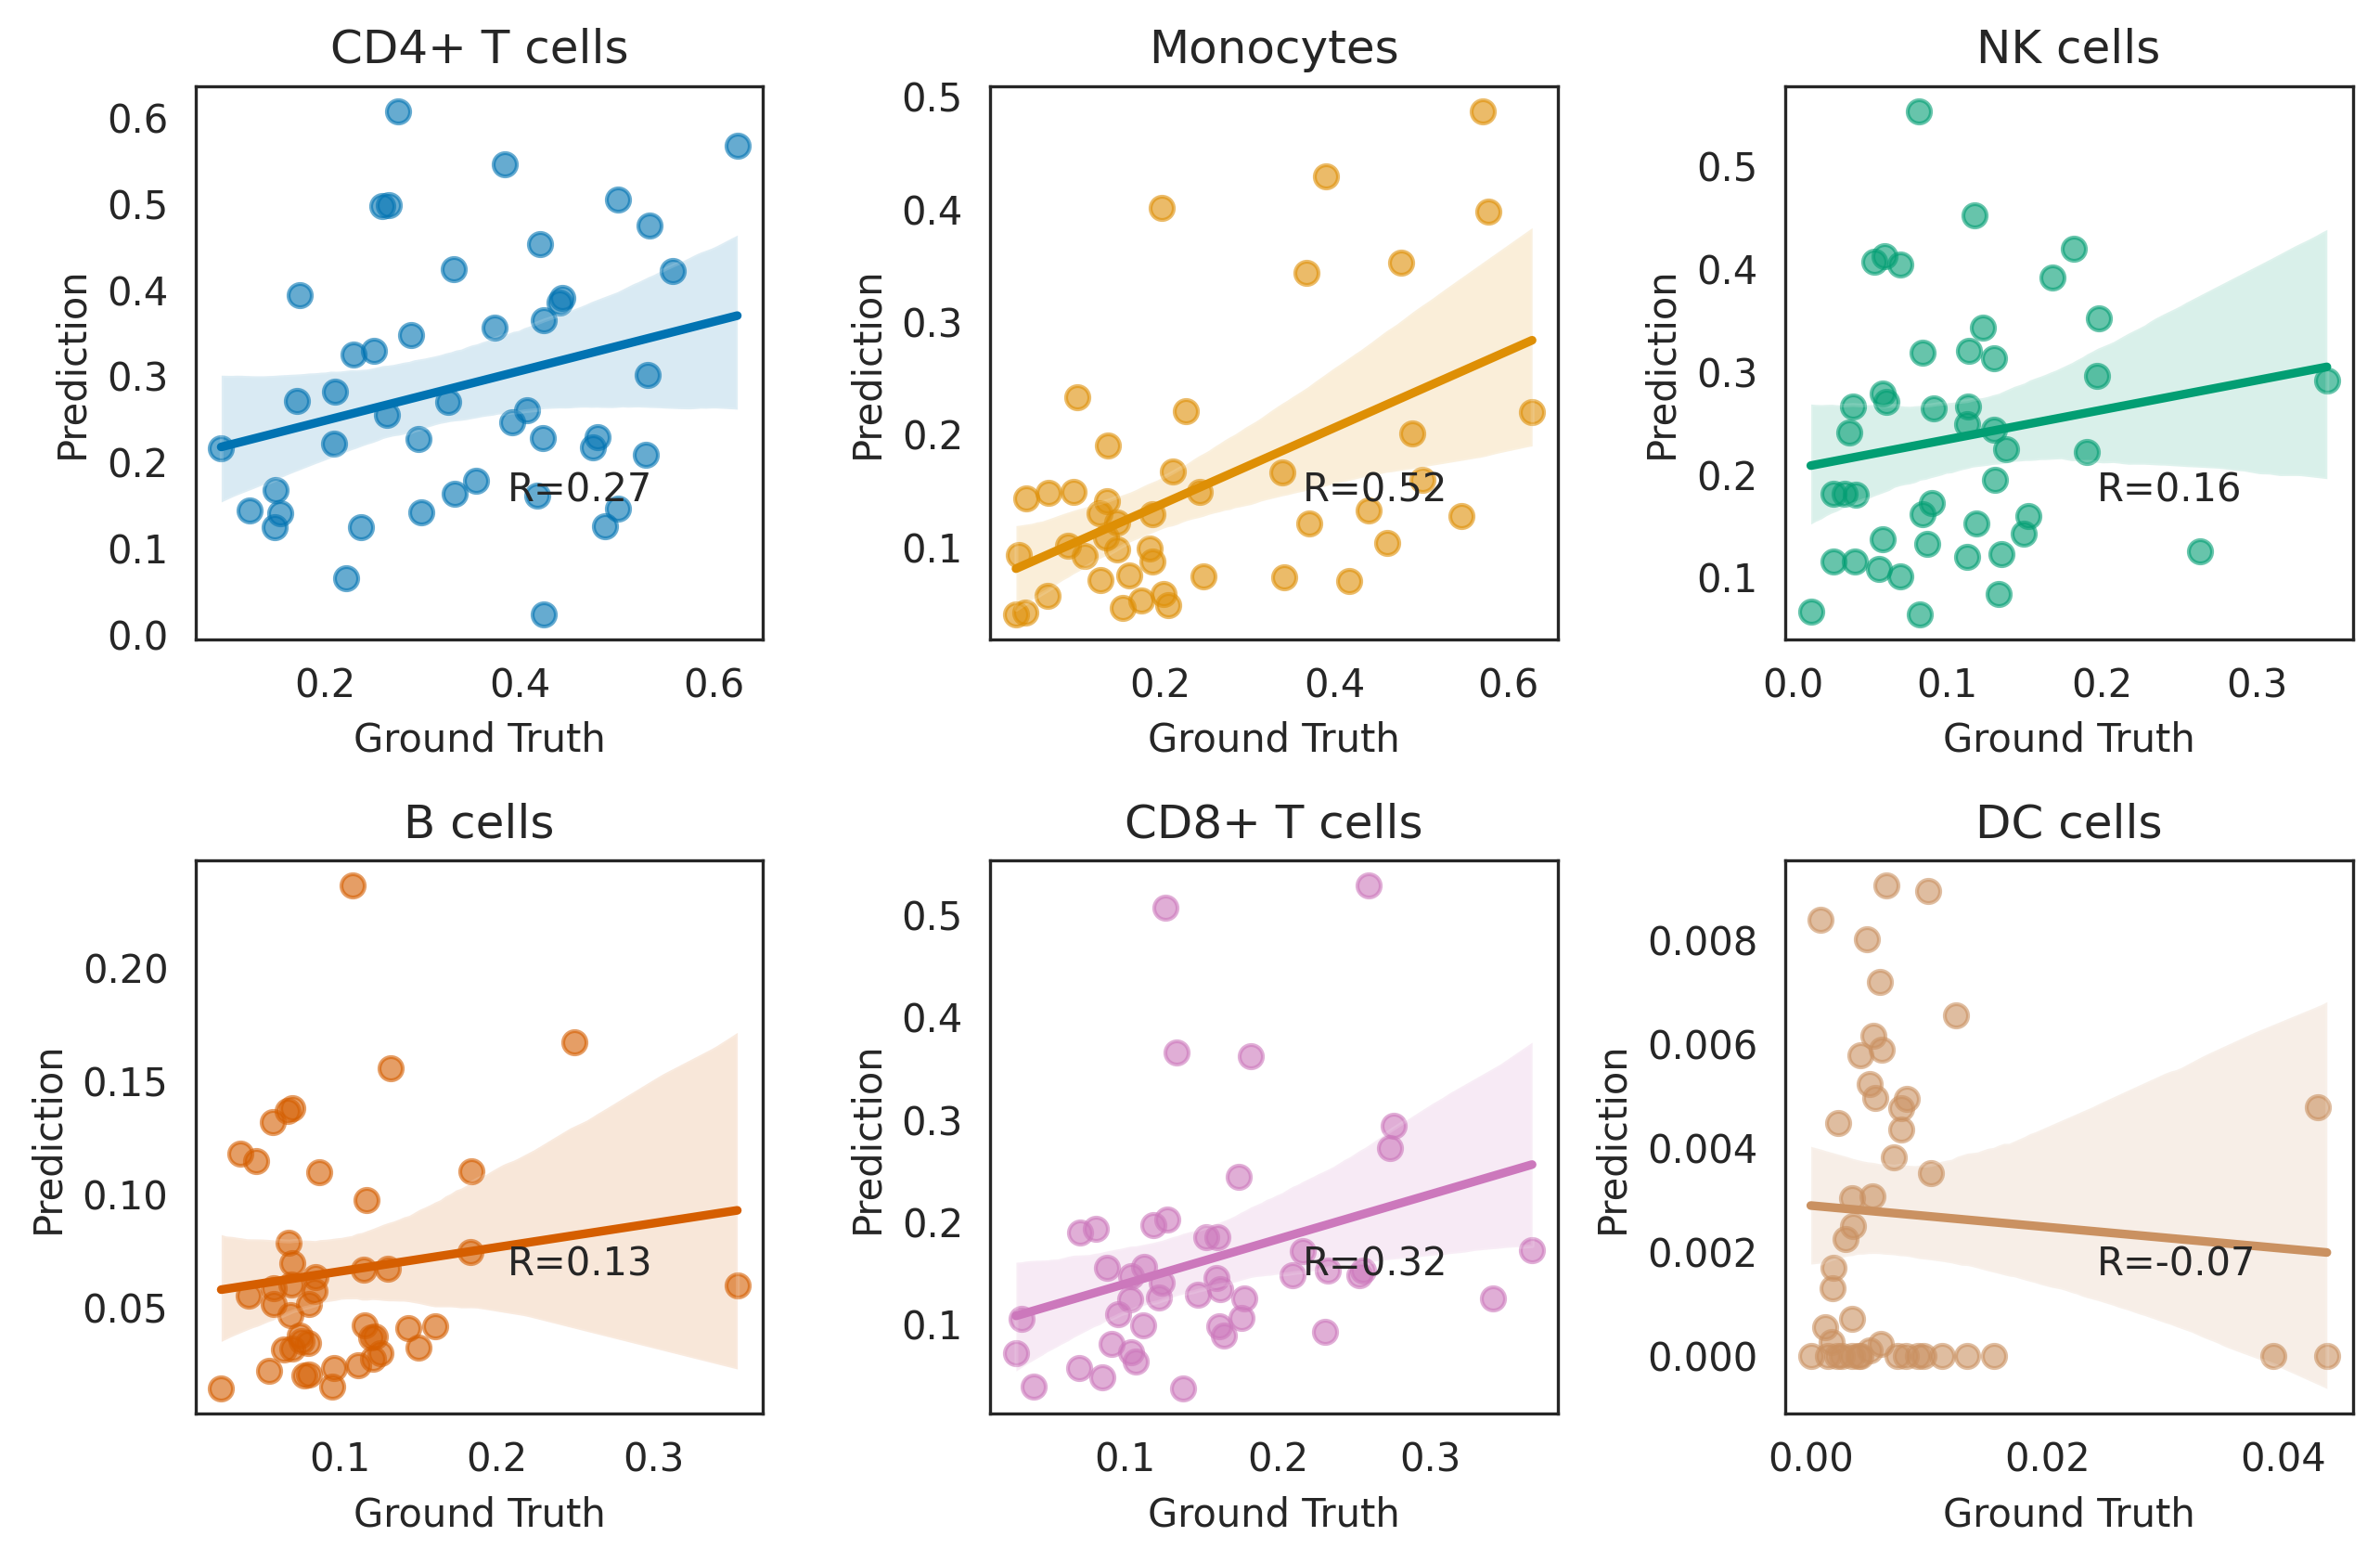

In [508]:
palette = sns.color_palette('colorblind')
plt.figure(figsize=(10,10), dpi=300)
plt.title('CIBERSORTx')
plt.figure(1)
loc = 331
color_index = 0
for i in cluster_names:
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    ax = plt.subplot(loc)
    plt.title(i)
    sns.regplot(x='Ground Truth', y='Prediction',
                data=correlation_list_csx[correlation_list_csx['Cluster name']==i], color=palette[color_index],
                scatter_kws={'alpha':0.6})
    ax.text(0.55,0.25,'R='+format(r_coeff[color_index],'.2f'), transform=ax.transAxes)
    loc+=1
    color_index+=1

# Correlation comparison between AIm and CSx

In [267]:
correlation_list_aim = correlation_list_csx
correlation_list_aim['Prediction'] = validation_3[validation_3['Prediction or GT']=='AIm Prediction']['Proportion']

# Venn map of DE genes and selected genes

In [464]:
import sys
sys.path.append(r'/home/aimmunelab/pyvenn')
import venn

In [465]:
dgelist_hm = pd.read_csv('dgelist_hm.csv', index_col='Unnamed: 0')
dgelist_hs = pd.read_csv('dgelist_hs.csv', index_col='Unnamed: 0')
dgelist_ms = pd.read_csv('dgelist_ms.csv', index_col='Unnamed: 0')
rf_selected_genes = pd.read_csv('RF_selected_genes.csv', index_col='Unnamed: 0')

In [467]:
labels = []
for i in [dgelist_hm, dgelist_hs, dgelist_ms]:
    labels.append(i['Gene.name'].values)
labels.append(rf_selected_genes['Gene name'].values)
labels = venn.get_labels(labels)

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

<Figure size 4800x2700 with 0 Axes>

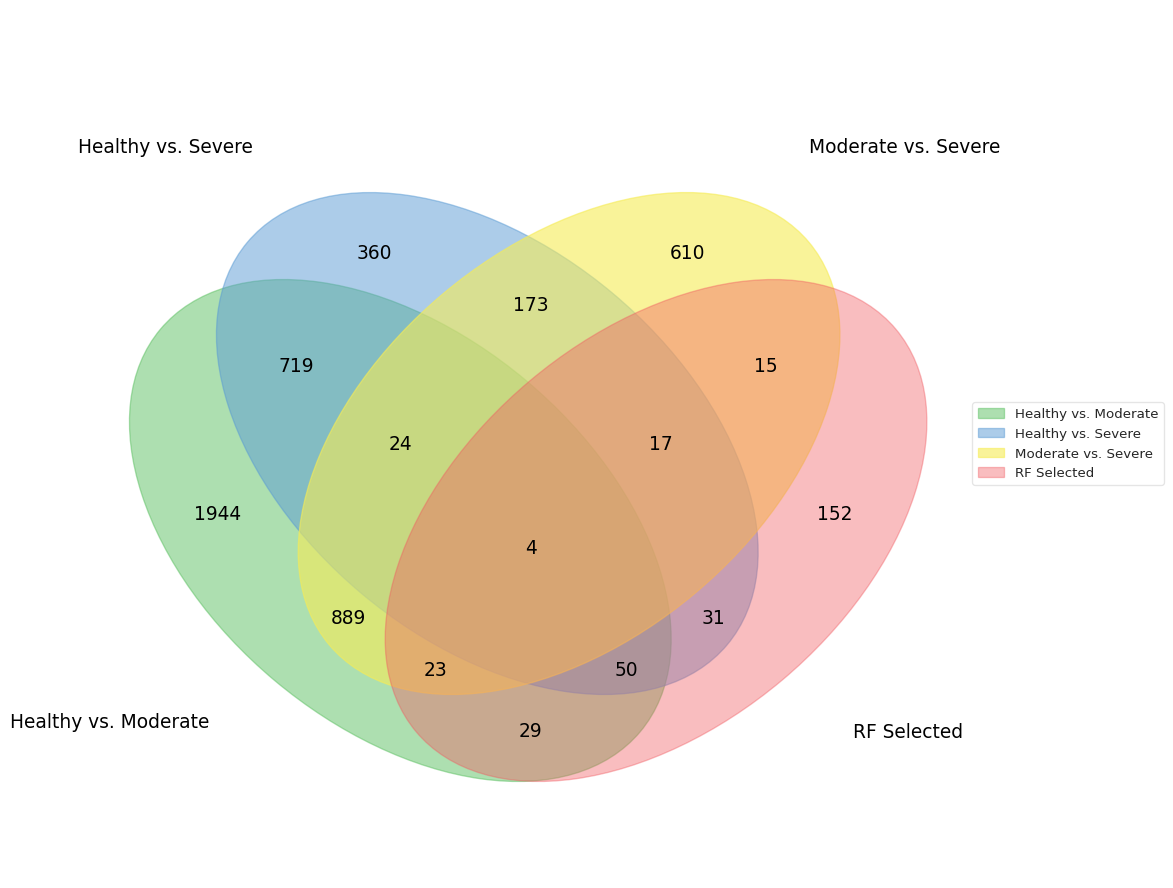

In [468]:
plt.figure(figsize=(16,9), dpi=300)
venn.venn4(labels, names = ['Healthy vs. Moderate', 'Healthy vs. Severe', 'Moderate vs. Severe', 'RF Selected'])